<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Ресемплирование" data-toc-modified-id="Ресемплирование-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Ресемплирование</a></span></li><li><span><a href="#Декомпозиция" data-toc-modified-id="Декомпозиция-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Декомпозиция</a></span></li><li><span><a href="#Тест-Дики-Фуллера" data-toc-modified-id="Тест-Дики-Фуллера-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Тест Дики-Фуллера</a></span></li><li><span><a href="#Выделение-признаков" data-toc-modified-id="Выделение-признаков-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Выделение признаков</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Разделение-на-выборки" data-toc-modified-id="Разделение-на-выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Разделение на выборки</a></span></li><li><span><a href="#Масштабирование-признаков" data-toc-modified-id="Масштабирование-признаков-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Масштабирование признаков</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#Результаты" data-toc-modified-id="Результаты-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Результаты</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем нужные библиотеки

In [1]:
!pip install shap

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

In [3]:
SEED = 42

In [4]:
pd.options.display.float_format ='{:,.3f}'.format

Сохранение исходного набора данных с учётом столбца индексов и приведением его к формату дат datetime64:

In [5]:
# загрузка данных:
try:
    df_taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    display('Something is wrong')

In [6]:
# Сортировка набора данных по столбцу индексов:
df_taxi.sort_index(inplace=True)

In [7]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [8]:
df_taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [9]:
df_taxi.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
num_orders,"26,496.000",14.070,9.211,0.000,8.000,13.000,19.000,119.000


In [10]:
# Проверка хронологического порядка временного ряда:
print('Хронологический порядок соблюдён:', df_taxi.index.is_monotonic)

Хронологический порядок соблюдён: True


In [11]:
# Проверим на пропуски:
print('Кол-во пропусков:')
df_taxi.isna().sum()

Кол-во пропусков:


num_orders    0
dtype: int64

***Вывод:***
* Датасет содержит 26496 записей о кол-ве заказов такси за 6 месяцев (с марта по август 2018 года), фиксируемых каждый 10 минут.
* Данные соответствуют предоставленному описанию и представляют собой временной ряд.
* Хронологический порядок соблюден.
* Пропусков нет.

## Анализ

### Ресемплирование

Задача исследования заключается в прогнозировании значений столбца `num_orders` на следующий час, а данные собраны за каждые 10 минут, проведем ресемплирование, и объединим записи в промежутке одного часа и рассчитаем сумму заказов такси, за это время.

In [12]:
df = df_taxi.copy()

In [13]:
df = df.resample('1H').sum()

In [14]:
print('Размер набора данных:', df.shape)

Размер набора данных: (4416, 1)


In [15]:
df_m_s = df.copy()
df_m_s['mean'] = df_m_s['num_orders'].shift().rolling(24).mean()
df_m_s['std'] = df_m_s['num_orders'].shift().rolling(24).std()

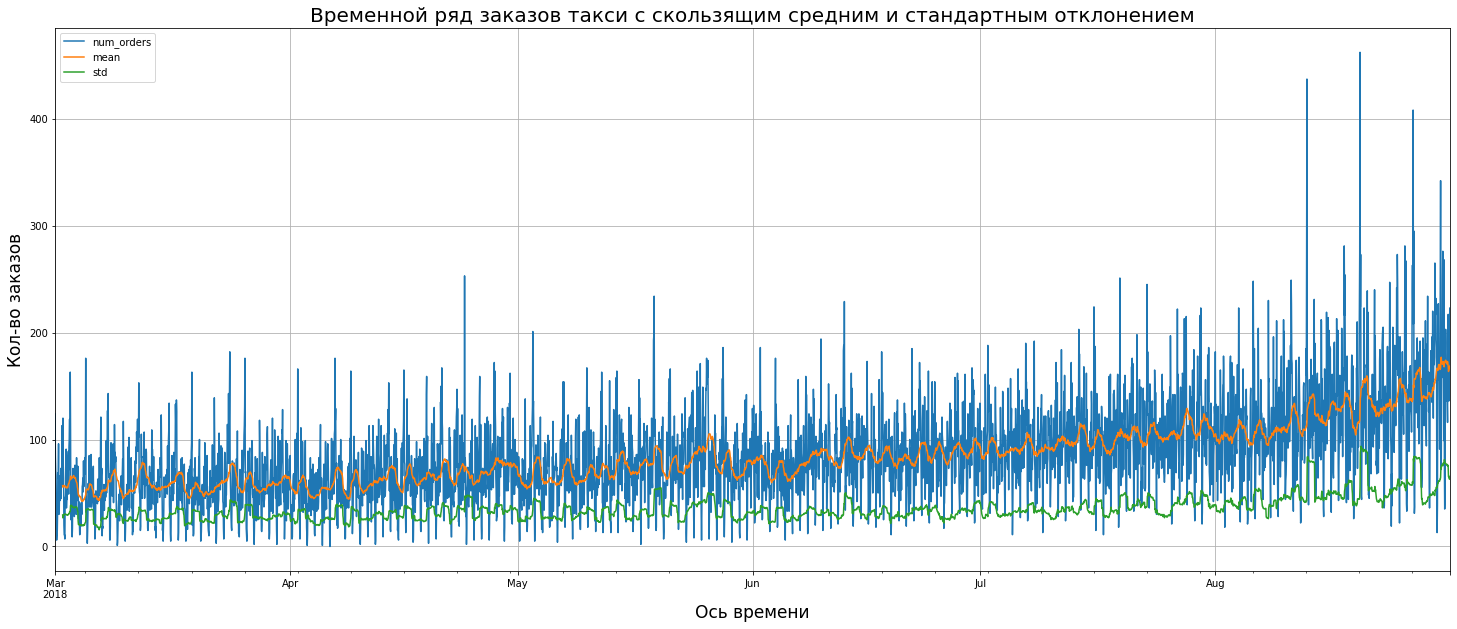

In [16]:
df_m_s.plot(figsize=(25, 10))
plt.title('Временной ряд заказов такси с скользящим средним и стандартным отклонением', size=20)
plt.xlabel('Ось времени', size=17)
plt.ylabel('Кол-во заказов', size=17)
plt.grid();

* На графике можно заметить восходящий тренд.
* В конце датасета наблюдается большой разброс показателей. Может быть выражено в большой разности между метриками на обучающих и тестовых данных.
* Временной ряд не стационарный. Меняется среднее значение и стандартное отклонение.

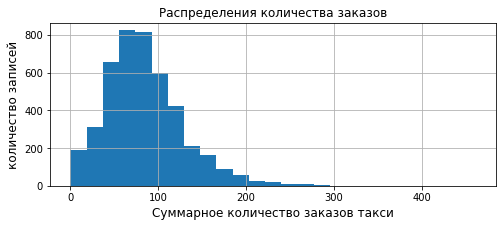

In [17]:
# визуализация количества записей относительно суммарного количества заказов такси
plt.figure(figsize=(8,3))
plt.hist(df['num_orders'], bins=25)
plt.grid(True)
plt.title('Распределения количества заказов')
plt.xlabel('Суммарное количество заказов такси', fontsize=12)
plt.ylabel('количество записей', fontsize=12)

plt.show()

* Данные имеют значения, близкие к нормальному распределению.
* Присутствуют значения, которые значительно отличаются от среднего, но обработка их не представляется возможным, т.к. нарушится хронологический порядок записей, что приведет к искажению реальных данных.

### Декомпозиция

Посмотрим на графики тренда и сезонности:

In [18]:
decomposed = seasonal_decompose(df['num_orders'])

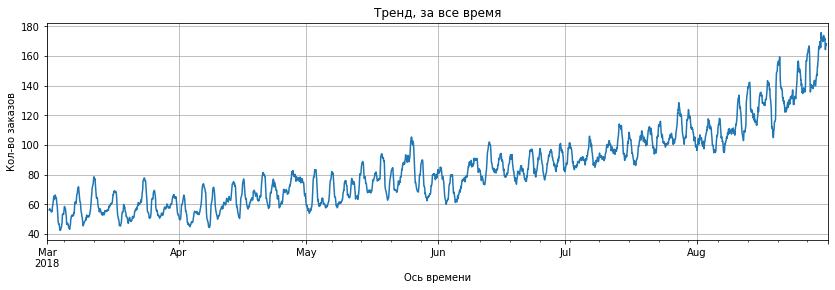

In [19]:
decomposed.trend.plot(grid=True ,ax=plt.gca(), figsize=(14, 4))
plt.title('Тренд, за все время')
plt.xlabel('Ось времени')
plt.ylabel('Кол-во заказов');

* Видим восходящий тренд за все время наблюдений.

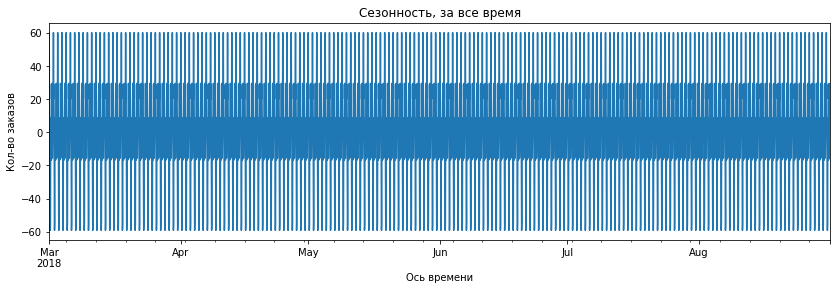

In [20]:
decomposed.seasonal.plot(ax=plt.gca(),figsize=(14, 4))
plt.title('Сезонность, за все время')
plt.xlabel('Ось времени')
plt.ylabel('Кол-во заказов');

* График сезонности за все время не дает ясной картины - рассмотрим данные на меньшем промежутке, за последние 7 дней:

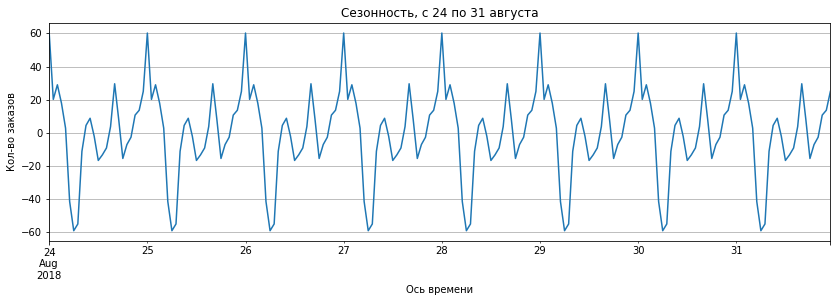

In [21]:
decomposed.seasonal['2018-08-24':'2018-08-31'].plot(grid=True, ax=plt.gca(),figsize=(14, 4))
plt.title('Сезонность, с 24 по 31 августа')
plt.xlabel('Ось времени')
plt.ylabel('Кол-во заказов');

* Для сравнения возьмем такой же трехдневный промежуток, но в середине мая:

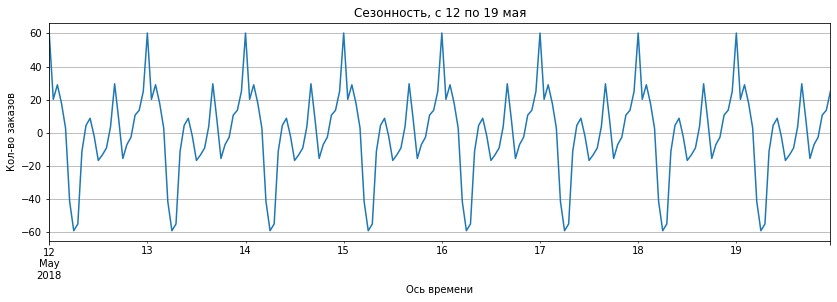

In [22]:
decomposed.seasonal['2018-05-12':'2018-05-19'].plot(grid=True, ax=plt.gca(),figsize=(14, 4))
plt.title('Сезонность, с 12 по 19 мая')
plt.xlabel('Ось времени')
plt.ylabel('Кол-во заказов');

* Графики идентичны - сезонность не зависит от тренда.

Рассмотрим один день:

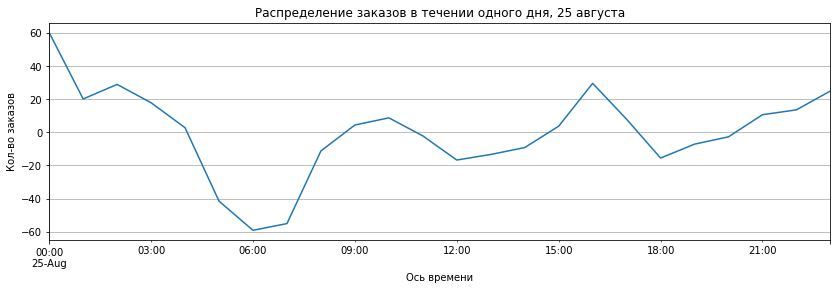

In [23]:
decomposed.seasonal['2018-08-25':'2018-08-25'].plot(grid=True, ax=plt.gca(),figsize=(14, 4))
plt.title('Распределение заказов в течении одного дня, 25 августа')
plt.xlabel('Ось времени')
plt.ylabel('Кол-во заказов');

* Пик заказов приходится на полночь, минимум - на 6 утра.

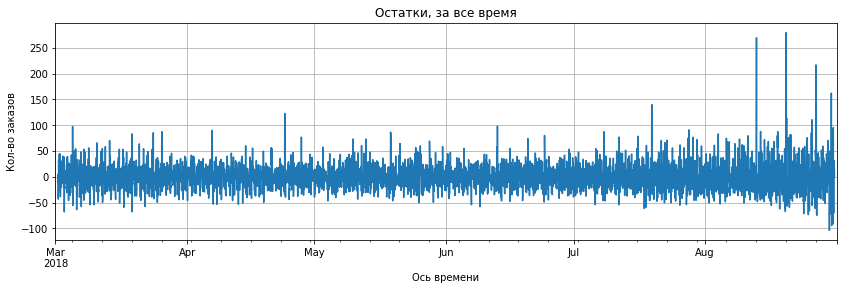

In [24]:
decomposed.resid.plot(grid=True, ax=plt.gca(),figsize=(14, 4))
plt.title('Остатки, за все время')
plt.xlabel('Ось времени')
plt.ylabel('Кол-во заказов');

Все так же большой разброс показателей в конце датасета (август) на графикке остатков. Ожидаемо приведет к увеличению разности между метриками на обучающих и тестовых данных.

### Тест Дики-Фуллера

Гипотезы:

H 0 : Временной ряд является нестационарным. 

H A : Временной ряд является стационарным.

In [25]:
# Тест Дики-Фуллера:
ts = df['num_orders']
st_test = adfuller(ts)
# если значение с индексом 1 меньше P-Value (0.05), то ряд приводим к стационарному
if st_test[1] < 0.05: print('Временной ряд является стационарным.')
else: print('Временной ряд является нестационарным.')
print('p-value: ', st_test[1])

Временной ряд является стационарным.
p-value:  0.028940051402612906


* Гипотеза, что ряд стационарный, не может быть отвергнута.

Для принятия решения о стационарности ряда проведем дополнительные тесты:

Тест Дики-Фуллера на уровне значимости 0.01:

Гипотезы:

H 0 : Временной ряд является нестационарным. 

H A : Временной ряд является стационарным.

In [26]:
# Тест Дики-Фуллера на уровне значимости 0.01:
ts = df['num_orders']
st_test = adfuller(ts)
# если значение с индексом 1 меньше P-Value (0.01), то ряд приводим к стационарному
if st_test[1] < 0.01: print('Временной ряд является стационарным.')
else: print('Временной ряд является нестационарным.')
print('p-value: ', st_test[1])

Временной ряд является нестационарным.
p-value:  0.028940051402612906


p-value не меньше 0,01 мы не можем отвергнуть нулевую гипотезу. Временной ряд является нестационарным.

Тест Кватковского-Филлипса-Шмидта-Шина (KPSS):

Гипотезы:  

H 0 : Временной ряд имеет стационарный тренд.  
H A : временной ряд не имеет стационарного тренда.

In [27]:
import statsmodels.api as sm

#perform KPSS test
test = sm.tsa.stattools.kpss(df, regression='ct')
if test[1] <= 0.01: print('Временной ряд является нестационарным.')
else: print('Временной ряд является стационарным.')
print('p-value: ', test[1])

Временной ряд является нестационарным.
p-value:  0.01


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Р-value значение меньше 0,05, мы отвергаем нулевую гипотезу теста KPSS. Временной ряд является нестационарным.

***Вывод:***
  
  - тест Дики-Фуллера (ADF) - временной ряд является нестационарным;
  - тест Кватковского-Филлипса-Шмидта-Шина (KPSS) - временной ряд является нестационарным;
  - Визуальное изучение графика временных рядов и разбиение его на трендовые, сезонные и остаточные компоненты -  
* На графике можно заметить восходящий тренд.  
* В конце датасета наблюдается большой разброс показателей. Может быть выражено в большой разности между метриками на обучающих и тестовых данных.
* Временной ряд не стационарный. Меняется среднее значение и стандартное отклонение. 
* Выявлена сезонность. 
    Временной ряд является нестационарным.

### Выделение признаков

Функция выделяющая необходимые для исследования признаки - столбцы с предыдущими значениями временного ряда, скользящее среднее, а также месяц, день, день недели и час. Год не понадобится, тк данные представлены только за 2018 год.

In [28]:
# Функция для создания дополнительных признаков
def make_features(df: pd.DataFrame, 
                  max_lag: int, 
                  rolling_window: int) -> pd.DataFrame:
    
    data = df.copy()
    # добавляем календарные признаки:
    #data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # добавляем сдвиги:
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    # добавляем скользящее среднее:
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_window).mean()
        
    data = data.dropna()
    
    return data

In [29]:
df_with_features = make_features(df, 24, 24)

In [30]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [31]:
df_with_features.head()

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2,4,0,58.000,113.000,66.000,61.000,45.000,73.000,...,34.000,15.000,12.000,6.000,43.000,66.000,71.000,85.000,124.000,56.833
2018-03-02 01:00:00,120,2,4,1,90.000,58.000,113.000,66.000,61.000,45.000,...,69.000,34.000,15.000,12.000,6.000,43.000,66.000,71.000,85.000,55.417
2018-03-02 02:00:00,75,2,4,2,120.000,90.000,58.000,113.000,66.000,61.000,...,64.000,69.000,34.000,15.000,12.000,6.000,43.000,66.000,71.000,56.875
2018-03-02 03:00:00,64,2,4,3,75.000,120.000,90.000,58.000,113.000,66.000,...,96.000,64.000,69.000,34.000,15.000,12.000,6.000,43.000,66.000,57.042
2018-03-02 04:00:00,20,2,4,4,64.000,75.000,120.000,90.000,58.000,113.000,...,30.000,96.000,64.000,69.000,34.000,15.000,12.000,6.000,43.000,56.958


In [32]:
df_with_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4392 non-null   int64  
 1   day           4392 non-null   int64  
 2   dayofweek     4392 non-null   int64  
 3   hour          4392 non-null   int64  
 4   lag_1         4392 non-null   float64
 5   lag_2         4392 non-null   float64
 6   lag_3         4392 non-null   float64
 7   lag_4         4392 non-null   float64
 8   lag_5         4392 non-null   float64
 9   lag_6         4392 non-null   float64
 10  lag_7         4392 non-null   float64
 11  lag_8         4392 non-null   float64
 12  lag_9         4392 non-null   float64
 13  lag_10        4392 non-null   float64
 14  lag_11        4392 non-null   float64
 15  lag_12        4392 non-null   float64
 16  lag_13        4392 non-null   float64
 17  lag_14        4392 non-null

Смотрим на распределение заказов по выделенным признакам (час, день недели, месяц)

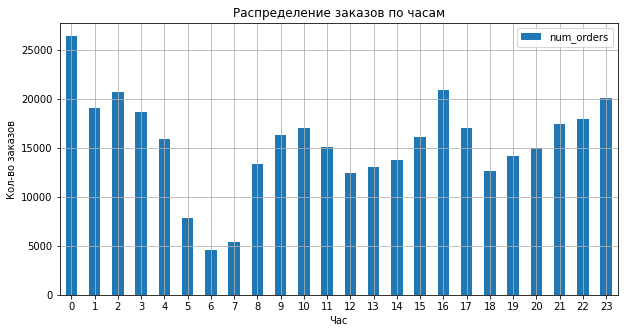

In [33]:
df_with_features.pivot_table(['num_orders'], ['hour'], aggfunc='sum').plot(kind='bar', grid=True, figsize=(10, 5))
plt.xticks(rotation=0)
plt.title('Распределение заказов по часам')
plt.xlabel('Час')
plt.ylabel('Кол-во заказов');

* Самый пиковый час - полночь, затем 2 и 16 часов. Наименьшее кол-во заказов происходит с 5 до 7 утра.

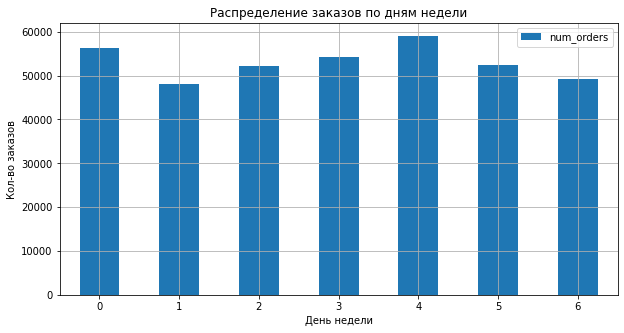

In [34]:
df_with_features.pivot_table(['num_orders'], ['dayofweek'], aggfunc='sum').plot(kind='bar', grid=True, figsize=(10, 5))
plt.xticks(rotation=0)
plt.title('Распределение заказов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Кол-во заказов');

* По дням недели пиковые дни - пятница и понедельник.

* Кол-во заказов растет с марта по август

## Обучение

### Разделение на выборки

In [35]:
# Выделяем признаки и целевой признак:
features = df_with_features.drop('num_orders', axis=1)
target = df_with_features['num_orders']

In [36]:
# Разбиваем данные на выборки: обучающую и тестовую - в соотношении 90/10:
X_train, X_test, y_train, y_test = train_test_split(features, target, shuffle=False, test_size=0.1)

In [37]:
# Смотрим размеры выборок на кодированных данных:
for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)

(3952, 28)
(440, 28)
(3952,)
(440,)


### Масштабирование признаков

In [38]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

In [39]:
# Смотрим размеры выборок на кодированных данных:
for i in [X_train_s, X_test_s, y_train, y_test]:
    print(i.shape)

(3952, 28)
(440, 28)
(3952,)
(440,)


Функция для обучения моделей и вычиcления RMSE:

In [40]:
def model_cv(model, param_grid, n_split):
    tscv = TimeSeriesSplit(n_splits=n_split)
    grid = GridSearchCV(model, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv, verbose=False)
    grid.fit(X_train_s, y_train)
    rmse = round(abs(grid.best_score_), 3)
    print(grid.best_params_)
    print('RMSE на cv:', rmse) 
    return rmse

### LinearRegression

In [41]:
model = LinearRegression()
rmse_lr = round(abs(cross_val_score(model, X_train, y_train, 
                         cv = TimeSeriesSplit(n_splits=8), 
                         n_jobs = -1, 
                         scoring = 'neg_root_mean_squared_error').mean()), 3)
print('RMSE на cv:', rmse_lr)

RMSE на cv: 26.609


### DecisionTreeRegressor

In [42]:
params =  {'max_depth': range (1, 13, 2),
           'min_samples_leaf': range (1, 8),
           'min_samples_split': range (2, 10, 2)}

rmse_dt = model_cv(DecisionTreeRegressor(random_state=SEED), params, 8)

{'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 2}
RMSE на cv: 28.802


### RandomForestRegressor

In [43]:
params =  {'n_estimators': range(100, 155, 15),
           'max_depth': range (5, 15, 5)}
rmse_rf = model_cv(RandomForestRegressor(random_state=SEED), params, 8)

{'max_depth': 10, 'n_estimators': 115}
RMSE на cv: 24.639


### CatBoostRegressor

In [44]:
params =  {'depth': range (1,10),
           'learning_rate': (0.03, 0.1)}

rmse_cb = model_cv(CatBoostRegressor(verbose=False, random_state=SEED), params, 8)

{'depth': 6, 'learning_rate': 0.03}
RMSE на cv: 23.676


### Результаты

In [45]:
results = pd.DataFrame([
    [rmse_lr],
    [rmse_dt],
    [rmse_rf],
    [rmse_cb]], 
    columns=['RMSE_cv'],
    index=['LinearRegression', 'DecisionTree', 'RandomForest', 'CatBoost'])

results.sort_values(by='RMSE_cv')

,RMSE_cv
CatBoost,23.676
RandomForest,24.639
LinearRegression,26.609
DecisionTree,28.802


Результаты оценки качества для всех моделей входят в заданное значение 48, лучший результат RMSE показывает CatBoost, худший результат у модели решающего дерева.

* Все модели показали практически одинаковые метрики качества и удовлетваряютусловие задачи RMSE < 48.
* Наилучшая метрика у модели, на основе алгоритма CatBoost, RMSE на данных для обучения составили 23.513. Данную модель, используем для проверки на тестовых данных.

## Тестирование

In [46]:
model_cb = CatBoostRegressor(depth=6, learning_rate=0.03, random_state=SEED,verbose=False)
model_cb.fit(X_train_s, y_train)
y_pred = model_cb.predict(X_test_s)
rmse_cb_test = round(mean_squared_error(y_test, y_pred)**0.5, 3)

print('RMSE на тестовой выборке:', rmse_cb_test)

RMSE на тестовой выборке: 40.526


Значение RMSE для CatBoost на тестовой выборке входит в заданное значение 48.

График сравнения реальных и предсказанных значений:

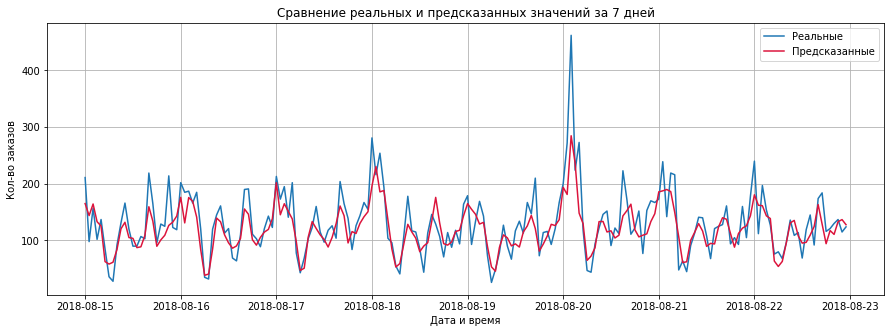

In [47]:
y_pred = pd.Series(y_pred, index=y_test.index)
plt.figure(figsize=(15, 5))
plt.xlabel('Дата и время')
plt.ylabel('Кол-во заказов')
plt.plot(y_test['2018-08-15':'2018-08-22'], label='Реальные')
plt.plot(y_pred['2018-08-15':'2018-08-22'], label='Предсказанные', color='crimson')
plt.title('Cравнение реальных и предсказанных значений за 7 дней')
plt.legend();
plt.grid(True)

В спокойные часы модель предсказывает неплохо, тогда как в пиковые часы ошибается достаточно сильно. 

Проанализируем важность основных факторов

In [48]:
explainer = shap.TreeExplainer(model_cb)
shap_values = explainer.shap_values(X_train)

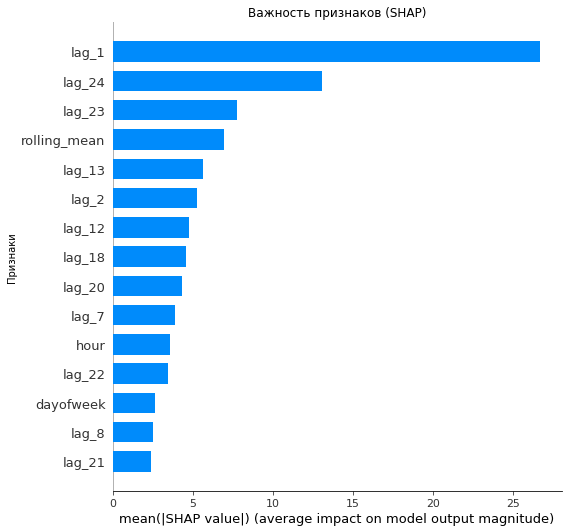

In [49]:
plt.title('Важность признаков (SHAP)')
plt.ylabel('Признаки')
plt.xlabel('Уровень важности');
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display = 15)

Модель выделила 'lag_1' и 'lag_24', как самые важные признаки.

**Проверка модели на адекватность**

* Модель будет предсказывать следующее значение предыдущим

In [50]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]

In [51]:
# оценка модели на тестовой выборке
print(f'RMSE-test: {round(mean_squared_error(y_test, pred_previous)**0.5, 2)}')

RMSE-test: 58.88


Выбранная модель, CatBoostRegressor, справляется лучше модели, предсказывающей текущее значение, предыдущим.

* DummyRegressor

In [52]:
model_db = DummyRegressor()
model_db.fit(X_train_s, y_train)
y_pred = model_db.predict(X_test_s)
rmse_dr = round(mean_squared_error(y_test, y_pred)**0.5, 3)

print('RMSE на тестовой выборке:', rmse_dr)

RMSE на тестовой выборке: 84.688


In [53]:
results_t = pd.DataFrame([
    [rmse_cb_test],
    [rmse_dr]], columns=['RMSE_test'],
    index=['CatBoost', 'Dummy'])

results_t.sort_values(by='RMSE_test')

,RMSE_test
CatBoost,40.526
Dummy,84.688


Модель адекватна и лучше константной.

### Вывод:

* Произведен комплексный анализ и построение моделей для прогнозирования количества заказов такси в периоды пиковой нагрузки. 
* Исходный датасет был перегруппирован: новый временной интервал 1 час. Все объекты за этот период были объединены и заказы просуммированы. Дубликаты и пропуски данных - отсутствуют. Хронологичный порядок соблюден в течение всего периода: 1 марта 2018 - 31 августа 2018.
* Тренды, помимо пульсаций, имеют прослеживаемый линейный рост. Сезонность имеет одинаковую повторяемость: суточную, недельную и месячную, но в слабо выраженная. Определен перечень признаков и их размеры:

    - сдвиг (количество заказов за 24 предыдущих часа);
    - скользящее среднее (среднее количество заказов за 24 ближайших часа);
    - месяц;
    - день месяца;
    - день недели;
    - час.
    Получившаяся выборка относительно небольшая и для подбора гиперпараметров моделей использовалась кросс-вылидация, с учётом хронологического порядка.
    
* Рассмотрены четыре различные модели: 
    - LinearRegression, 
    - DecisionTreeRegressor,
    - RandomForestRegressor,
    - CatBoostRegressor.
* Модель на основе алгоритма CatBoostRegressor показала наилучшее качество с наименьшим значением метрики RMSE на кросс-валидации. Вск модели уложились в заданное условие RNSE < 48.
* Выбранная модель способна достичь значения метрики RMSE на тесте в рамках заданных требований, что подтверждает ее пригодность для решения данной задачи. 
* Модель адекватна и лучше константной.